<a href="https://colab.research.google.com/github/karl-karlsson/notebooks/blob/main/chinook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You can open a copy of this notebook in Google Colab by clicking the icon above

---
# Combining pandas and SQL to analyze sales data for a digital media store

# About the project
The chinook database is a sample database  created from personal iTunes. It's meant to replicate sales data for a digital media store. I've downloaded the data from [here](https://www.sqlitetutorial.net/sqlite-sample-database/) and you can also read more about the database [here](https://github.com/lerocha/chinook-database).

The picture below displays the schema for the database:

![](https://blog.xojo.com/wp-content/uploads/2016/04/ChinookDatabaseSchema1.1.png)


(The table names are inconsistent with the the tablenames in the downloaded database. But column names and relationsships bewtween keys are consistent.) 
 
In a previous life I used to manage a record store. So although this is "mockup-data" it still feels somewhat familiar. My old record store in Växjö, Sweden pictured below:

![](https://static-cdn.sr.se/images/106/1531478_1200_675.jpg?preset=1024x576)

In this project I will use a combination of Python and SQL to do five things:

* Create some helper functions that makes querying the database from Python a breeze
* Try to answer four business questions:
  * What albums to buy based on genre statistics?
  * How do sales differ between employees?
  * How do sales differ between countries?
  * What buy patterns are typical of customers - do they buy albums or individual tracks?

First step is to import the required libraries:
*  `urllib` to download the file
* `sqlite3` and `pandas` for querying and transforming the data
* `plotnine` for plotting 

In [70]:
import urllib.request
import sqlite3
import pandas as pd
import plotnine as gg

...and download the file

In [71]:
urllib.request.urlretrieve("https://github.com/karl-karlsson/data/raw/main/chinook.db", "chinook.db")


('chinook.db', <http.client.HTTPMessage at 0x7fab4ccab610>)

# Creating helper functions

To make querying easier we'll create six different helper functions:

* `run_query()`
* `show_tables()`
* `run_sequence()`
* `glance()`
* `get_all()`

## `run_query()`

First we'll create the run_query() function. It takes a SQL query ("string") as an argument and returns a pandas dataframe of that query.

In [72]:
def run_query(q) :
  with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [73]:
q = """
SELECT *
FROM artists
LIMIT 3;
"""

run_query(q)

,ArtistId,Name
0,1,AC/DC
1,2,Accept
2,3,Aerosmith


## `show_tables()`

Next is the `show_tables()`. It calls the `run_query()` function and returns a list of all tables and views in the database.

In [74]:
def show_tables() :
  q = """
SELECT 
    name
FROM 
    sqlite_master
WHERE 
    type ='table' AND 
    name NOT LIKE 'sqlite_%';
  """
  return run_query(q)

In [75]:
show_tables()

,name
0,albums
1,artists
2,customers
3,employees
4,genres
5,invoices
6,invoice_items
7,media_types
8,playlists
9,playlist_track


## `run_command()`

We'll also define a `run_command()` function that takes a SQL command as an argument and executes it using the sqlite module. This is to run querys that don't return tables (for example `CREATE VIEW`). The `conn.isolation_level = None` sets the connection to autocommit mode which means that the SQL statement is automatically executed (read more on this on [StackOverflow](https://stackoverflow.com/questions/4699605/why-doesn-t-sqlite3-require-a-commit-call-to-save-data) or in the [sqlite3 docs](https://docs.python.org/3/library/sqlite3.html#sqlite3.Connection.isolation_level).

In [76]:
def run_command(c) :
  with sqlite3.connect('chinook.db') as conn:
    conn.isolation_level = None
    conn.execute(c)

In [77]:
c = """
CREATE VIEW artists_copy
AS 
   SELECT *
   FROM artists;
"""

run_command(c)

q = """
SELECT *
FROM artists_copy
LIMIT 5;
"""
run_query(q)

,ArtistId,Name
0,1,AC/DC
1,2,Accept
2,3,Aerosmith
3,4,Alanis Morissette
4,5,Alice In Chains


In [78]:
c = """
DROP VIEW artists_copy
"""

run_command(c)

## `run_sequence()`

The `run_sequence` function will allow us to run mutiple commands (in order) by creating an empty list and appending new commands in the order they are meant to be executed.

The function will also automatically print out the commands but this feature can be turned off by setting `out=False`.

In [79]:
def run_sequence(a_list_of_commands, out=True) :
  for command in a_list_of_commands :
    run_command(command)
    if out==True:
      print(command)

commands = []

commands.append("""
CREATE TABLE new_table_1 AS
  SELECT *
  FROM customers;
""")

commands.append("""
CREATE TABLE new_table_2 AS
  SELECT *
  FROM customers;
""")

commands.append("""
DROP TABLE new_table_1;
""")

run_sequence(commands)


CREATE TABLE new_table_1 AS
  SELECT *
  FROM customers;


CREATE TABLE new_table_2 AS
  SELECT *
  FROM customers;


DROP TABLE new_table_1;



In [80]:
show_tables()

,name
0,albums
1,artists
2,customers
3,employees
4,genres
5,invoices
6,invoice_items
7,media_types
8,playlists
9,playlist_track


In [81]:
run_command("DROP TABLE new_table_2")

## `glance()`

Sometimes you want to "glance" a table by for example running:

  `SELECT *
  FROM some_table LIMIT 5;`

So let's create a function that makes this a bit easier.

In [82]:
def glance(table) :
  q = "SELECT * FROM " + table + " LIMIT 5;"
  return run_query(q)

In [83]:
glance("invoice_items")

,InvoiceLineId,InvoiceId,TrackId,UnitPrice,Quantity
0,1,1,2,0.99,1
1,2,1,4,0.99,1
2,3,2,6,0.99,1
3,4,2,8,0.99,1
4,5,2,10,0.99,1


## `get_all()`


The `get_all()` function simply gets all rows from a table.

In [84]:
def get_all(table) :
  q = "SELECT * FROM " + table + " ;"
  return run_query(q) 

# Selecting albums to purchase

Let's say we want to know what genre is the most popular in the U.S.
This seems like a pretty typical business question.

We'll write a query that returns each genre, with the number of tracks sold in the USA in absolut numbers and percentage of total sales.

Based on the results we'll look into what albums might be prioritized to keep in stock.


In [85]:
q = """
WITH 

/* Tracks sold in US (tsu) */
tsu AS

(
SELECT 
  SUM(Quantity) AS TracksSold,
  ii.TrackId,
  g.Name AS Genre
  FROM invoice_items AS ii
LEFT JOIN invoices AS i ON ii.InvoiceId = i.InvoiceId
LEFT JOIN tracks AS t ON ii.TrackId = t.TrackId
LEFT JOIN genres AS g ON t.GenreId = g.GenreId
WHERE i.BillingCountry ="USA"
GROUP BY ii.TrackId
),

/* Total tracks sold (tts) */
tts AS

(
SELECT
  SUM(TracksSold) AS tts
  FROM tsu
)

/* Main query */
SELECT 
  Genre,
  SUM(TracksSold) AS TotalSales,
  ROUND(CAST(SUM(TracksSold) AS FLOAT) / tts.tts , 2) AS Percentage
FROM tsu, tts
GROUP BY Genre
ORDER BY TotalSales DESC
LIMIT 5;
"""

run_query(q)

,Genre,TotalSales,Percentage
0,Rock,157,0.32
1,Latin,91,0.18
2,Metal,64,0.13
3,Alternative & Punk,50,0.10
4,Jazz,22,0.04


Rock, latin and metal are the three most popular categories accounting for > 60 percent of sales. Let's see which artists within these genres are the most popular. 

In [86]:
q = """
WITH 

/* Tracks sold by artist (tsa) */
tsa AS

(
SELECT
  art.Name AS Artist,
  g.Name AS Genre,
  SUM(Quantity) AS TracksSold
  FROM invoice_items AS ii
LEFT JOIN invoices AS i ON ii.InvoiceId = i.InvoiceId
LEFT JOIN tracks AS t ON ii.TrackId = t.TrackId
LEFT JOIN genres AS g ON t.GenreId = g.GenreId
LEFT JOIN albums AS alb ON t.AlbumId = alb.AlbumId
LEFT JOIN artists AS art ON alb.ArtistId = art.ArtistId
GROUP BY art.Name
)

SELECT
  MAX(TracksSold) AS Max,
  Artist,
  Genre
FROM tsa
WHERE Genre IN ("Metal", "Latin", "Rock")
GROUP BY Artist, Genre
ORDER BY TracksSold DESC
LIMIT 10;
"""

run_query(q)

,Max,Artist,Genre
0,140,Iron Maiden,Rock
1,107,U2,Rock
2,91,Metallica,Metal
3,87,Led Zeppelin,Rock
4,45,Os Paralamas Do Sucesso,Latin
5,44,Deep Purple,Rock
6,40,Eric Clapton,Latin
7,37,Creedence Clearwater Revival,Rock
8,37,Queen,Rock
9,36,Guns N' Roses,Metal


Based on these results Iron Maiden (Rock), Metallica (Metal) and Os Paralamas Do Sucesso (Latin) are three artists that are likely important to keep in stock at all times to satisfy potential customers.

# Analyzing employee sales performance

Analyzing performance by employees is an important part of running a successful company. Results can serve as basis for learning and feedback or for performance evaluation.

When a customer makes a first buy the customer gets assigned to a sales support agent. This is the 'SupportRepId' column in the 'customers' table.

Purchases by customers are in the ´invoices´ table. Data about customers, such as name and adress, are in the `customers` table. Data about employees, for example title, are in the `employees` table. 

It would be nice to have a table with sales for each employee and month. Since this doesn't exist we'll create it.
For this purpose we'll create a view `monthly_sales` by

* summarizing purchases made by each customer for each month
* join the results to the `employees` table 
* write a final query that selects name, month and total sales for each employee

We can then query this view with the `get_all()` function and plot the results.




In [87]:
show_tables()

,name
0,albums
1,artists
2,customers
3,employees
4,genres
5,invoices
6,invoice_items
7,media_types
8,playlists
9,playlist_track


In [88]:
glance('customers')

,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId
0,1,Luís,Gonçalves,Embraer - Empresa Brasileira de Aeronáutica S.A.,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,+55 (12) 3923-5555,+55 (12) 3923-5566,luisg@embraer.com.br,3
1,2,Leonie,Köhler,None,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,+49 0711 2842222,None,leonekohler@surfeu.de,5
2,3,François,Tremblay,None,1498 rue Bélanger,Montréal,QC,Canada,H2G 1A7,+1 (514) 721-4711,None,ftremblay@gmail.com,3
3,4,Bjørn,Hansen,None,Ullevålsveien 14,Oslo,None,Norway,0171,+47 22 44 22 22,None,bjorn.hansen@yahoo.no,4
4,5,František,Wichterlová,JetBrains s.r.o.,Klanova 9/506,Prague,None,Czech Republic,14700,+420 2 4172 5555,+420 2 4172 5555,frantisekw@jetbrains.com,4


In [89]:
glance('employees')

,EmployeeId,LastName,FirstName,Title,ReportsTo,BirthDate,HireDate,Address,City,State,Country,PostalCode,Phone,Fax,Email
0,1,Adams,Andrew,General Manager,NaN,1962-02-18 00:00:00,2002-08-14 00:00:00,11120 Jasper Ave NW,Edmonton,AB,Canada,T5K 2N1,+1 (780) 428-9482,+1 (780) 428-3457,andrew@chinookcorp.com
1,2,Edwards,Nancy,Sales Manager,1.0,1958-12-08 00:00:00,2002-05-01 00:00:00,825 8 Ave SW,Calgary,AB,Canada,T2P 2T3,+1 (403) 262-3443,+1 (403) 262-3322,nancy@chinookcorp.com
2,3,Peacock,Jane,Sales Support Agent,2.0,1973-08-29 00:00:00,2002-04-01 00:00:00,1111 6 Ave SW,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,+1 (403) 262-6712,jane@chinookcorp.com
3,4,Park,Margaret,Sales Support Agent,2.0,1947-09-19 00:00:00,2003-05-03 00:00:00,683 10 Street SW,Calgary,AB,Canada,T2P 5G3,+1 (403) 263-4423,+1 (403) 263-4289,margaret@chinookcorp.com
4,5,Johnson,Steve,Sales Support Agent,2.0,1965-03-03 00:00:00,2003-10-17 00:00:00,7727B 41 Ave,Calgary,AB,Canada,T3B 1Y7,1 (780) 836-9987,1 (780) 836-9543,steve@chinookcorp.com


In [90]:
c = """

CREATE VIEW monthly_sales AS

WITH 

/* Purchases by customer and month (p) */
p AS 
(
SELECT
  i.CustomerId,
  SupportRepId,
  DATETIME(i.InvoiceDate, 'start of month') AS Month,
  SUM(Total) AS Total
FROM invoices AS i
LEFT JOIN customers AS c ON i.CustomerId = c.CustomerId 
GROUP BY c.CustomerId
),

/* Purchases per employee (ppe)*/
ppe AS
(
SELECT
  Month,
  SupportRepId,
  SUM(Total) AS Total
FROM p
GROUP BY SupportRepId, Month
)

/* Main query */
SELECT 
  ppe.*,
  e.FirstName || " " || e.LastName AS EmployeeName
FROM ppe
LEFT JOIN employees AS e ON ppe.SupportRepId = e.EmployeeId
ORDER BY Month DESC, Total DESC;

"""

run_command(c)

In [91]:
glance("monthly_sales")

,Month,SupportRepId,Total,EmployeeName
0,2013-12-01 00:00:00,3,117.86,Jane Peacock
1,2013-12-01 00:00:00,5,80.24,Steve Johnson
2,2013-12-01 00:00:00,4,75.24,Margaret Park
3,2013-11-01 00:00:00,5,87.24,Steve Johnson
4,2013-11-01 00:00:00,3,85.24,Jane Peacock


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


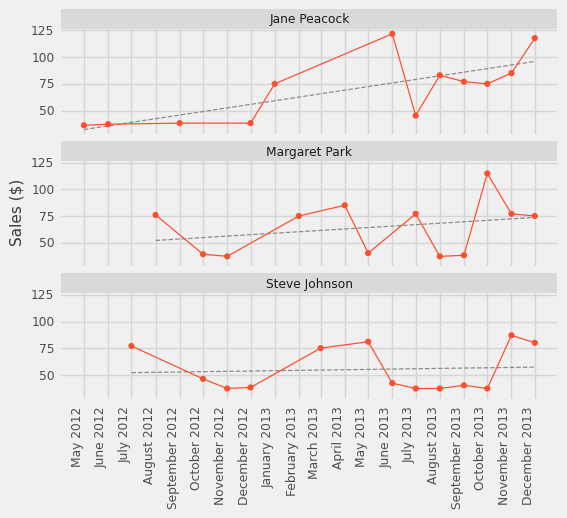

<ggplot: (8773354887917)>

In [92]:
import plotnine as gg
from mizani.breaks import date_breaks
from mizani.formatters import date_format

(
gg.ggplot(get_all("monthly_sales"), gg.aes(x='Month', y='Total', group="EmployeeName"))
+gg.geom_smooth(method='lm', se=False, linetype='dashed', size=1/2, color="#8b8b8b")
+gg.geom_line(color="#fc4f30")
+gg.geom_point(color="#fc4f30")
+gg.facets.facet_wrap("EmployeeName",nrow=3,ncol=1)
+gg.scales.scale_x_datetime(breaks=date_breaks('1 month'), labels=date_format('%B %Y')) 
+gg.themes.theme_538()
+gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=1))
+gg.labs(x="", y="Sales ($)")
)

The plot above shows sales by each employee on the Y-axis and time on the X-axis. Both Jane and Margaret are showing increasing monthly sales. 

Steve where perhaps absent or were given other tasks between june 2013 and november 2013.

# Analyzing sales by country

Our next task is to analyze the sales data for customers from each different country. Based on this analysis we'll try to make some recomendations on how to allocate our marketing budget.

In [93]:
#NTS: This could come first to explain how many countries and customers there are

q = """
SELECT 
  COUNT(DISTINCT Country) AS 'Number of countries',
  COUNT(DISTINCT CustomerId) AS 'Number of customers'
FROM customers"""

run_query(q)

,Number of countries,Number of customers
0,24,59


Running the query above shows that there are 59 customers in 24 different countries.  

For each country we want to know:
* the total number of customers for each country
* total value of sales 
* average value of sales per customer

There are some countries with only one customer. We'll group these customers as "Other" in our analysis. By creating a column for sorting (`sort`) we'll force `Other` to the bottom of the table. 

To get a final table that holds the information we want we'll run 4 consecutive commands. For this we'll use the `run_sequence()` function that holds SQL commands as a list and runs them in order. 


In [94]:
commands = []

commands.append("DROP TABLE IF EXISTS temp_table")
commands.append("DROP TABLE IF EXISTS sales_by_country")

commands.append("""
/* Using WITH to create two named subqueries */
CREATE TABLE temp_table AS 

/* Customers per country (cpc) */
WITH  cpc AS
(
  SELECT
    Country, 
    COUNT(*) AS NrCustomers
  FROM customers
  GROUP BY Country
),

/* Purchases by customer (pbc)*/
pbc AS
(
  SELECT
    CustomerId, 
    SUM(Total) AS Total
  FROM invoices
  GROUP BY CustomerId
)

/* Main query */
SELECT
  c.*,
  cpc.NrCustomers,
  pbc.Total,
  CASE 
    WHEN cpc.NrCustomers = 1 THEN 0
    ELSE 1 END AS sort
FROM customers AS c
LEFT JOIN cpc ON c.Country = cpc.Country
LEFT JOIN pbc ON c.CustomerId=pbc.CustomerId;
"""
)


commands.append("""
UPDATE temp_table
SET Country = 'Other'
WHERE NrCustomers = 1;
"""
)

commands.append("""
CREATE TABLE sales_by_country AS 
SELECT
  Country,
  COUNT(*) AS NrCustomers,
  CAST(SUM(Total) AS INTEGER) AS TotalSalesValue,
  CAST(AVG(Total) AS INTEGER) AS AvgSalesValue
FROM temp_table
GROUP BY Country
ORDER BY sort DESC, NrCustomers DESC;
"""
)

commands.append("""
DROP TABLE temp_table;
"""
)


In [95]:
run_sequence(commands, out=False)
get_all("sales_by_country")

,Country,NrCustomers,TotalSalesValue,AvgSalesValue
0,USA,13,523,40
1,Canada,8,303,37
2,Brazil,5,190,38
3,France,5,195,39
4,Germany,4,156,39
5,United Kingdom,3,112,37
6,Czech Republic,2,90,45
7,India,2,75,37
8,Portugal,2,77,38
9,Other,15,604,40


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


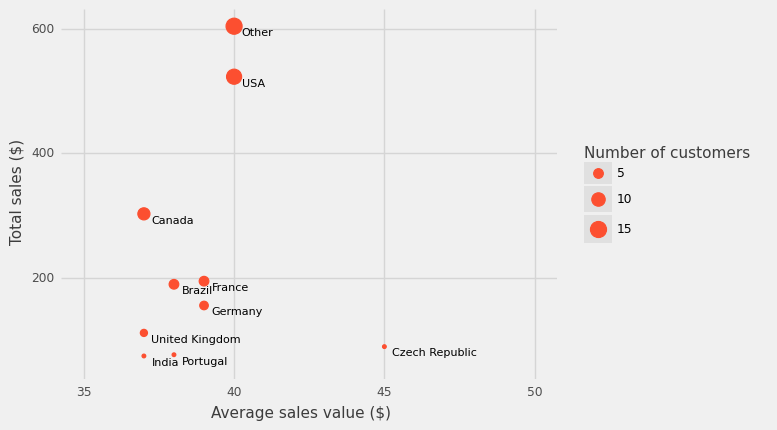

<ggplot: (8773356549917)>

In [96]:
(
gg.ggplot(get_all("sales_by_country"), gg.aes(x='AvgSalesValue', y='TotalSalesValue', label='Country'))
+gg.geom_text(ha="left",nudge_y=-10, nudge_x=0.25, size=8)
+gg.geom_point(gg.aes(size="NrCustomers"), color="#fc4f30")
+gg.scales.xlim(35,50)
+gg.themes.theme_538()
+gg.labs(x="Average sales value ($)", y="Total sales ($)", size="Number of customers")
)

The plot above shows that there are two countries that stands out namely Canada and the Czech Republic.

The typical customer in Canada spends a little less per purchase than customers from other countries. One idea could be to focus on upsell activities such as better recomendations or bundled discounts.

The typical customer from the Czech Republic spends more than customers from other countries. Assuming this is representative or other Czech customers the focus should be to increase the number of Czech customers. Activites such as personal invite campaigns (from other customers) or external advertising could perhaps help with this.  

( As stated in the beginning this "mock-up data". But if this was real data a sample size of 59 customers in total, 8 for Canada and 2 for the Czech Republic is would of course be to small to support good decision making ). 

# Album vs individual tracks

In the invoice table each purchase by a customer either represents an album purchase or purchase of indiviudal songs/tracks. But the type of purchase is not stated on the invoice. 

This digital media store can choose to purchase albums or individual songs

In [97]:
glance("invoice_items")

,InvoiceLineId,InvoiceId,TrackId,UnitPrice,Quantity
0,1,1,2,0.99,1
1,2,1,4,0.99,1
2,3,2,6,0.99,1
3,4,2,8,0.99,1
4,5,2,10,0.99,1


In [98]:
commands = []

commands.append("DROP TABLE IF EXISTS album_tracks")
commands.append("DROP TABLE IF EXISTS invoice_album_tracks")

commands.append("""
/* Creates a table with nr of tracks from each album */
CREATE TABLE album_tracks AS
SELECT
  a.AlbumId,
  COUNT(DISTINCT t.TrackId) AS NrTracks  
FROM tracks AS t
LEFT JOIN albums AS a ON t.AlbumId = a.AlbumId
GROUP BY a.AlbumId;
""")

commands.append("""
/* Creates a table with nr of tracks bought from each invoice / album combination */
CREATE TABLE invoice_album_tracks AS
SELECT
  ii.InvoiceId,
  t.AlbumId,
  COUNT(DISTINCT ii.TrackId) AS NrTracksInvoice  ,
  at.NrTracks AS NrTracksAlbum
FROM invoice_items AS ii
LEFT JOIN tracks AS t ON ii.TrackId = t.TrackId
LEFT JOIN album_tracks AS at ON t.AlbumId = at.AlbumId
GROUP BY ii.InvoiceId, t.AlbumId;

""")

commands.append("""
DROP TABLE album_tracks
""")

run_sequence(commands, out=False)

In [99]:
q = """
WITH temp AS
    (SELECT 
      InvoiceId,
      AlbumId,
      CASE
        WHEN NrTracksInvoice = NrTracksAlbum THEN 1
        ELSE 0 END AS whole_album
    FROM invoice_album_tracks),

    temp2 AS
    (SELECT
      InvoiceId,
      MIN(whole_album) AS is_album_purchase
    FROM temp
    GROUP BY InvoiceId, AlbumId)

SELECT ROUND(AVG(is_album_purchase) * 100, 2) AS 'Percent album purchases'
FROM temp2
"""

run_query(q)

,Percent album purchases
0,3.76


According to our analysis only around four percent of customers buy albums. T
If the media store stops buying whole albums from record companies this likely wouldn't be catastrophic for sales but other parameters primarily the effect on purchase prices should be considered. 

# Conclusions

This analys have shown that:

* Rock, latin and metal are the most popular categories and that Iron Maiden (Rock), Metallica (Metal) and Os Paralamas Do Sucesso (Latin) are the most popular artists within those categories
* Customers are scattered arund the world and there are many countries with only single customers
* Marketing campaigns targeting Canada (upsell) and the Czech Republic (customer acquisition) could be rewarding
* Most customers buy individual tracks rather than whole albums 

# Contact details

![bild](https://avatars.githubusercontent.com/u/99097833?v=4)

Feel free to reach out:

* Twitter: [@vaxjo_kalle](https://twitter.com/vaxjo_kalle) 
* LinkedIn: [My profile](https://www.linkedin.com/in/karlkarlssonvaxjo/)
* E-mail: [karl_karlsson@icloud.com](mailto:karl_karlsson@icloud.com)
* GitHub: [github.com/karl-karlsson](https://github.com/karl-karlsson)